In [1]:
#https://github.com/znxlwm/pytorch-generative-model-collections/blob/master/WGAN.py
#https://wiseodd.github.io/techblog/2017/02/04/wasserstein-gan/

In [2]:
%matplotlib inline

In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np

import math
import itertools
import os
import time

from utils import time_since

In [4]:
#get data

from data_utils import load_mnist

trX, _, _, _ = load_mnist(onehot=False)

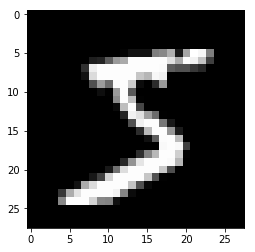

In [5]:
#view data

plt.imshow(trX[0].reshape(28,28), cmap=plt.get_cmap('gray')) #need cmap thing or else is weird colour

In [6]:
#create generator

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [7]:
#create discriminator

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #wgan has no sigmoid on outputs of D
        return x

In [8]:
#hyper parameters

batch_size = 32
z_size = 100
hidden_size = 500
epochs = 50

In [9]:
#create instance of generator and discriminator

G = Generator(z_size, hidden_size, trX.shape[1])
D = Discriminator(trX.shape[1], hidden_size, 1)

In [10]:
#define loss function and optimizer

criterion = nn.MSELoss() #wgan no longer outputs probabilities, so this is now MSE instead of BCE
G_optimizer = torch.optim.Adam(G.parameters())
D_optimizer = torch.optim.Adam(D.parameters())

In [11]:
#function for training the discriminator

def train_discriminator(discriminator, discriminator_optimizer, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    discriminator_optimizer.step()
    
    for p in discriminator.parameters():
        p.data.clamp_(-0.01, 0.01)
    
    return d_loss, real_score, fake_score

In [12]:
#function for training the generator

def train_generator(generator, generator_optimizer, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    generator_optimizer.step()
    return g_loss

In [13]:
def train(generator, discriminator, generator_optimizer, discriminator_optimizer, criterion, images):
    
    #real images have a label of 1
    real_labels = Variable(torch.ones((images.size(0),1))) #images.size(0) gets batch size
    
    for _ in range(5):
        #sample from generator
        noise = Variable(torch.randn(images.size(0), 100)) #TODO: change 100 to z_size
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros((images.size(0), 1)))

        #train discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, discriminator_optimizer, images, real_labels, fake_images, fake_labels)
    
    # Sample again from the generator and get output from discriminator
    noise = Variable(torch.randn(images.size(0), 100)) #TODO: change 100 to z_size
    fake_images = generator(noise)
    outputs = discriminator(fake_images)
                     
    #train generator
    g_loss = train_generator(generator, generator_optimizer, outputs, real_labels)
                
    return g_loss.data[0], d_loss.data[0]

In [ ]:
def create_samples(generator, epoch):
    
    noise = Variable(torch.randn(32, 100))
    
    samples = generator(noise).data.numpy()[:16]
        
    fig = plt.figure(figsize=(4,4))
    gs = gridspec.GridSpec(4, 4)
    #gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    if not os.path.exists('out/wgan/'):
        os.makedirs('out/wgan/')

    plt.savefig('out/wgan/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
    plt.close(fig)

In [ ]:
#run the training

plot_G_loss = []
plot_D_loss = []
num_examples = trX.shape[0]
num_batches = num_examples // batch_size
trX = Variable(torch.FloatTensor(trX))

for e in range(1, epochs+1):
    
    start_time = time.time()
    
    G_loss, D_loss = 0, 0
    
    for k in range(num_batches):
        start, end = k * batch_size, (k + 1) * batch_size
        G_loss_batch, D_loss_batch = train(G, D, G_optimizer, D_optimizer, criterion, trX[start:end])
        G_loss += G_loss_batch
        D_loss += D_loss_batch
    
    create_samples(G, e)
    plot_G_loss.append(G_loss/num_batches)
    plot_D_loss.append(D_loss/num_batches) 
    print("Epoch %02d, G_loss = %f, D_loss = %f, epoch time: %s" % (e, G_loss / num_batches, D_loss / num_batches, time_since(start_time)))

Epoch 01, G_loss = 0.934253, D_loss = 0.040182, epoch time: 6m 47s
Epoch 02, G_loss = 0.609822, D_loss = 0.204485, epoch time: 7m 8s
Epoch 03, G_loss = 0.526702, D_loss = 0.316230, epoch time: 7m 21s
Epoch 04, G_loss = 0.474375, D_loss = 0.372339, epoch time: 7m 41s
Epoch 05, G_loss = 0.442584, D_loss = 0.436506, epoch time: 8m 7s
Epoch 06, G_loss = 0.435548, D_loss = 0.463185, epoch time: 8m 23s
Epoch 07, G_loss = 0.428673, D_loss = 0.494870, epoch time: 8m 47s
